<a href="https://colab.research.google.com/github/dercodeKoenig/colab-KI/blob/main/xt_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir /root/.kaggle/
!echo '{"username":"bpwqsdd","key":"55c6bac7a9ea2f38dd966a1d1a4e31f8"}' > /root/.kaggle/kaggle.json
!pip uninstall kaggle -y
!python -m pip install kaggle

Found existing installation: kaggle 1.5.12
Uninstalling kaggle-1.5.12:
  Successfully uninstalled kaggle-1.5.12
     |████████████████████████████████| 58 kB 1.4 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=66c7effec3b10f7dbd0f07c8b53f03846558c1a26139393cddb7eaad1323b18d
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle


In [2]:
!kaggle datasets download -d amin233/forex-top-currency-pairs-20002020
!unzip forex-top-currency-pairs-20002020.zip

 15% 5.00M/33.5M [00:00<00:00, 47.2MB/s]
100% 33.5M/33.5M [00:00<00:00, 173MB/s] 
Archive:  forex-top-currency-pairs-20002020.zip
  inflating: AUDUSD-2000-2020-15m.csv  
  inflating: EURCHF-2000-2020-15m.csv  
  inflating: EURJPY-2000-2020-15m.csv  
  inflating: EURUSD-2000-2020-15m.csv  
  inflating: USDCAD-2000-2020-15m.csv  
  inflating: USDCHF-2000-2020-15m.csv  
  inflating: USDJPY-2000-2020-15m.csv  


In [3]:
!pip install ta
import time
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd    
import numpy as np
import datetime
import math
from IPython.display import clear_output
import ta
from tqdm import tqdm
import gc


  Created wheel for ta: filename=ta-0.9.0-py3-none-any.whl size=28908 sha256=bbe52fe28a9692be64b19826fc7768d647ca73a42b7a7f166511efe4ddd0d572
  Stored in directory: /root/.cache/pip/wheels/72/78/64/cc1c01506a1010a9845e9bd7c69333730f7174661228ea4f98
Successfully built ta


In [4]:
symbol = "EURUSD"
seq_len = int(128)
lookfuture = int(64)
atr_mult = 2
stop_loss_mult = 0.5
train_window = 1024

In [5]:
df = pd.read_csv("EURUSD-2000-2020-15m.csv")
df

,DATE_TIME,HIGH,LOW,OPEN,CLOSE
0,2000.01.03 00:00:00,1.00800,1.00730,1.00730,1.00770
1,2000.01.03 00:15:00,1.00870,1.00760,1.00780,1.00860
2,2000.01.03 00:30:00,1.00890,1.00790,1.00870,1.00790
3,2000.01.03 00:45:00,1.01320,1.00780,1.00780,1.01280
4,2000.01.03 01:00:00,1.01330,1.01200,1.01290,1.01220
...,...,...,...,...,...
500746,2020.03.19 05:00:00,1.09007,1.08790,1.08803,1.08895
500747,2020.03.19 05:15:00,1.08936,1.08807,1.08895,1.08872
500748,2020.03.19 05:30:00,1.09118,1.08853,1.08872,1.09086
500749,2020.03.19 05:45:00,1.09086,1.08946,1.09086,1.08970


In [6]:
class candle_class:
    t = 0
    o = 0
    h = 0
    l = 0
    c = 0
    sma21 = 0
    sma50 = 0
    sma200 = 0
    rsi14 = 0
    atr_value = 0
    dh = 0
    dl = 0
    
    action = -1
    candles_past = 0
    
    validated = False
    generated = False
    
    xexec = 0
    xexec_stop = 0
    
class manager:
    candles = []
    name = ""
    current_candle_time = 0
    model = 0
    
    def save_state(self):
        self.model.save(self.name)
        file = open(self.name+"_candle_time.txt", "w")
        file.write(str(self.current_candle_time))
        file.close()
        
    def create_model(self):
        self.model = self.make_model()
        self.model.summary()
    
    def restore(self):
        self.model = tf.keras.models.load_model(self.name)
        file = open(self.name+"_candle_time.txt", "r")
        text = file.read()
        file.close()
        self.current_candle_time = float(text)
        print("resume training from", self.current_candle_time)
    
    def __init__(self, name):
        self.name = name
    
    def make_model(self):
        inputs = tf.keras.layers.Input(shape = (seq_len, 9))
        x = inputs
        
        x = tf.keras.layers.Dense(16, kernel_regularizer=tf.keras.regularizers.l2(1e-4), bias_regularizer=tf.keras.regularizers.l2(1e-3))(x)
        x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
        x = tf.keras.layers.Dense(16, kernel_regularizer=tf.keras.regularizers.l2(1e-4), bias_regularizer=tf.keras.regularizers.l2(1e-3))(x)
        x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
        x = tf.keras.layers.Conv1D(16,3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(1e-4), bias_regularizer=tf.keras.regularizers.l2(1e-4))(x)
        x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
        
        x = tf.keras.layers.Dense(16, kernel_regularizer=tf.keras.regularizers.l2(1e-4), bias_regularizer=tf.keras.regularizers.l2(1e-3))(x)
        x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
        x = tf.keras.layers.Concatenate()([x, inputs])
       
        x = tf.keras.layers.Dense(16, kernel_regularizer=tf.keras.regularizers.l2(1e-4), bias_regularizer=tf.keras.regularizers.l2(1e-3))(x)
        x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
        
        x = tf.keras.layers.LSTM(16, activation = "tanh", kernel_regularizer=tf.keras.regularizers.l2(1e-4), return_sequences=False, bias_regularizer=tf.keras.regularizers.l2(1e-4))(x)
     
        x = tf.keras.layers.Dense(16, kernel_regularizer=tf.keras.regularizers.l2(1e-4), bias_regularizer=tf.keras.regularizers.l2(1e-3))(x)
        x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
        
        outputs = tf.keras.layers.Dense(3, activation = "softmax", kernel_regularizer=tf.keras.regularizers.l2(1e-2), bias_regularizer=tf.keras.regularizers.l2(1e-2))(x)
    
        model = tf.keras.Model(inputs, outputs)
    
        loss = tf.keras.losses.SparseCategoricalCrossentropy()
        opt = tf.keras.optimizers.SGD(learning_rate=0.00002, momentum=0.95, nesterov=True)
        #opt = tf.keras.optimizers.Adam(learning_rate=0.00002)
        model.compile(opt, loss, metrics="accuracy")
        return model
        
        
    
    def candles_to_dataframe(self, candles):
        o = [x.o for x in candles]
        h = [x.h for x in candles]
        l = [x.l for x in candles]
        c = [x.c for x in candles]
        data = {"Open":o, "High":h, "Low":l, "Close":c}
        df = pd.DataFrame(data)
        return df
    
    def add_new_candle(self, t,o,h,l,c):
        for i in range(len(self.candles)):
            self.candles[i].candles_past+=1
            
        new_candle = candle_class()
        new_candle.t = t
        new_candle.o = o
        new_candle.h = h
        new_candle.l = l
        new_candle.c = c
        self.candles.append(new_candle)
        
        if len(self.candles) >= 200:
            
            df = self.candles_to_dataframe(self.candles[-21:])
            sma21_raw = list(ta.trend.SMAIndicator(df["Close"], 21).sma_indicator())[-1]
            
            df = self.candles_to_dataframe(self.candles[-50:])
            sma50_raw = list(ta.trend.SMAIndicator(df["Close"], 50).sma_indicator())[-1]
            
            df = self.candles_to_dataframe(self.candles[-200:])
            sma200_raw = list(ta.trend.SMAIndicator(df["Close"], 200).sma_indicator())[-1]
            
            df = self.candles_to_dataframe(self.candles[-14:])
            rsi_14 = list(ta.momentum.RSIIndicator(df["Close"], 14).rsi())[-1] / 50 - 1

            df = self.candles_to_dataframe(self.candles[-40:])
            atr_value = list(ta.volatility.AverageTrueRange(df["High"], df["Low"], df["Close"], 40).average_true_range())[-1]
            
            df = self.candles_to_dataframe(self.candles[-21:])
            donchi = ta.volatility.DonchianChannel(df["High"], df["Low"], df["Close"], 21)
            dh = list(donchi.donchian_channel_hband())[-1]
            dl = list(donchi.donchian_channel_lband())[-1]
            
            new_candle.dh = dh
            new_candle.dl = dl
            new_candle.sma21 = sma21_raw
            new_candle.sma50 = sma50_raw
            new_candle.sma200 = sma200_raw
            new_candle.rsi14 = rsi_14
            new_candle.atr_value = atr_value
            new_candle.generated = True
            
            self.candles[-1] = new_candle
            
        
        
        if len(self.candles) >= lookfuture:
            to_validate = self.candles[-lookfuture]
            
            action_to_take = 0
            
            lout = False
            stop_down_long = to_validate.l - to_validate.atr_value * atr_mult * stop_loss_mult
            stop_up_long = to_validate.h + to_validate.atr_value * atr_mult

            sout = False
            stop_up_short = to_validate.h + to_validate.atr_value * atr_mult * stop_loss_mult
            stop_down_short = to_validate.l - to_validate.atr_value * atr_mult
            
            for i in range(-lookfuture+1, 0):
                high = self.candles[i].h
                low = self.candles[i].l
                
                if high > stop_up_long and not lout:
                    action_to_take = 2
                    break
                
                if low < stop_down_long:
                    lout = True
                    
                if low < stop_down_short and not sout:
                    action_to_take = 1
                    break
                
                if high > stop_up_short:
                    sout = True
                    
                
            self.candles[-lookfuture].action = action_to_take
                    
        if len(self.candles) > lookfuture + seq_len + train_window + 200:
            del self.candles[0]
        
        self.update_model()
        
        
    def sample_to_x_y(self, sample):
        
                current_close = sample[-1].c

                prev_close = [candle.c for candle in sample]
                prev_high = [candle.h for candle in sample]
                prev_low = [candle.l for candle in sample]

                prev_sma21 = [candle.sma21 for candle in sample]
                prev_sma50 = [candle.sma50 for candle in sample]
                prev_sma200 = [candle.sma200 for candle in sample]
                
                dl = [candle.dl for candle in sample]
                dh = [candle.dh for candle in sample]

                dl_relative = [-(current_close - dl[o]) / dl[o] for o in range(seq_len)]
                dh_relative = [-(current_close - dh[o]) / dh[o] for o in range(seq_len)]
                
                prev_sma21_relative = [-(current_close - prev_sma21[o]) / prev_sma21[o] for o in range(seq_len)]
                prev_sma50_relative = [-(current_close - prev_sma50[o]) / prev_sma50[o] for o in range(seq_len)]
                prev_sma200_relative = [-(current_close - prev_sma200[o]) / prev_sma200[o] for o in range(seq_len)]

                prev_close_relative = [-(current_close - prev_close[o]) / prev_close[o] for o in range(seq_len)]
                prev_high_relative = [-(current_close - prev_high[o]) / prev_high[o] for o in range(seq_len)]
                prev_low_relative = [-(current_close - prev_low[o]) / prev_low[o] for o in range(seq_len)]

                maxval = max(prev_high_relative)
                minval = min(prev_low_relative)
                scale = 1 / (maxval - minval)

                prev_sma21_relative_scaled = [i * scale for i in prev_sma21_relative]
                prev_sma50_relative_scaled = [i * scale for i in prev_sma50_relative]
                prev_sma200_relative_scaled = [i * scale for i in prev_sma200_relative]

                prev_close_relative_scaled = [i * scale for i in prev_close_relative]
                prev_low_relative_scaled = [i * scale for i in prev_low_relative]
                prev_high_relative_scaled = [i * scale for i in prev_high_relative]

                dl_rel_scaled = [i * scale for i in dl_relative]
                dh_rel_scaled = [i * scale for i in dh_relative]
                
                prev_rsi_14 = [candle.rsi14 for candle in sample]


                x = []
                for o in range(len(prev_close)):
                    ts = []
                    ts.append(prev_close_relative_scaled[o])
                    ts.append(prev_high_relative_scaled[o])
                    ts.append(prev_low_relative_scaled[o])

                    ts.append(prev_sma21_relative_scaled[o])
                    ts.append(prev_sma50_relative_scaled[o])
                    ts.append(prev_sma200_relative_scaled[o])
                    
                    ts.append(dh_rel_scaled[o])
                    ts.append(dl_rel_scaled[o])
                    
                    ts.append(prev_rsi_14[o])

                    x.append(ts)

                x = np.array(x)
                return x
        
    def get_current_inference_data(self):
            sample = self.candles[-seq_len:]
            inference_data = self.sample_to_x_y(sample)
            return inference_data
        
    train_ready_samples = []
    train_ready_labels = []
    def get_current_train_samples(self):
            if len(self.candles) < lookfuture + seq_len + 200:
                return None
            
            sample = self.candles[-seq_len-lookfuture:-lookfuture]
            
            x = self.sample_to_x_y(sample)
            self.train_ready_samples.append(x)
            self.train_ready_labels.append(sample[-1].action)
            
            if len(self.train_ready_labels) > train_window:
                del self.train_ready_labels[0]
                del self.train_ready_samples[0]
                
            
            if len(self.train_ready_labels) == train_window:
                train_ready_samples_np = np.array(self.train_ready_samples)
                train_ready_labels_np = np.array(self.train_ready_labels)
                return train_ready_samples_np, train_ready_labels_np
            else:
                return None

    def update_model(self):
        ret = self.get_current_train_samples()
        if self.current_candle_time < self.candles[-1].t:
            self.current_candle_time = self.candles[-1].t
            if ret != None:
                X, Y = ret
                self.model.fit(X, Y, batch_size = 32, shuffle = True, verbose = 2)
    
    def get_current_decision(self):
        if len(self.candles) < seq_len+200 or self.candles[-1].t != self.current_candle_time:
            return None
        inference_data = self.get_current_inference_data()
        inference_data = np.reshape(inference_data, (1, seq_len, -1))
        ri = self.model(inference_data)[0]
        print("value:", ri.numpy())
        result = np.argmax(ri)
        return result, ri

In [7]:
data_manager = manager("EUR_USD_MANAGER")
data_manager.create_model()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 9)]     0           []                               
                                                                                                  
 dense (Dense)                  (None, 128, 16)      160         ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 128, 16)      0           ['dense[0][0]']                  
                                                                                                  
 dense_1 (Dense)                (None, 128, 16)      272         ['leaky_re_lu[0][0]']            
                                                                                              

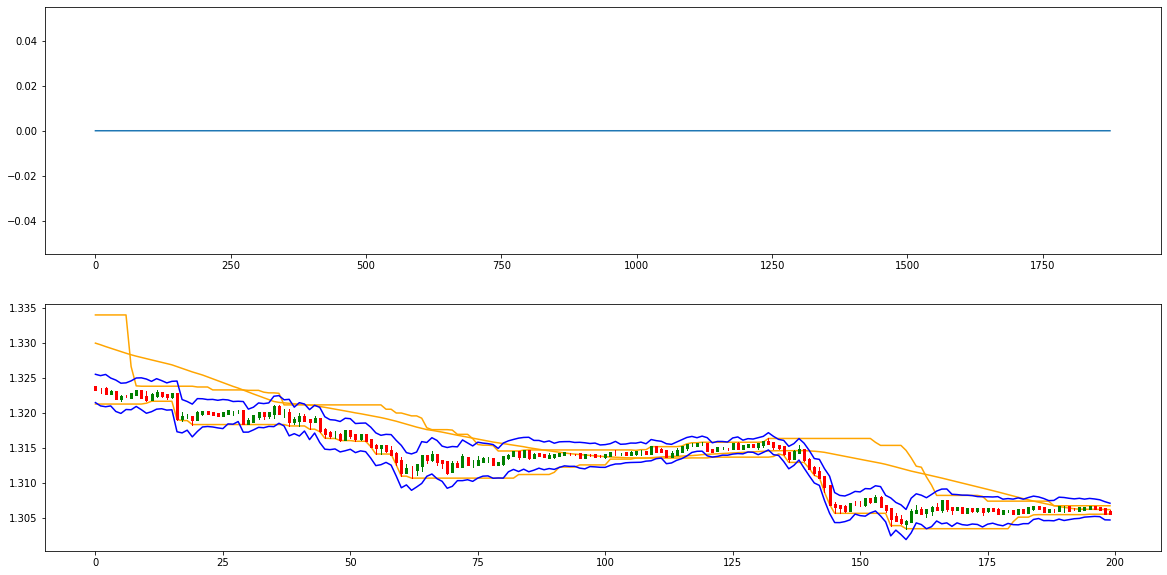

total: 0 0
32/32 - 1s - loss: 1.0703 - accuracy: 0.5010 - 1s/epoch - 35ms/step
value: [0.24110888 0.18021901 0.5786721 ]
32/32 - 1s - loss: 1.0701 - accuracy: 0.5010 - 1s/epoch - 34ms/step
value: [0.24069704 0.17982742 0.5794755 ]
32/32 - 1s - loss: 1.0702 - accuracy: 0.5000 - 1s/epoch - 34ms/step
value: [0.24108799 0.18056197 0.57835   ]
32/32 - 1s - loss: 1.0704 - accuracy: 0.5000 - 1s/epoch - 34ms/step
value: [0.2463389  0.18860447 0.5650566 ]
32/32 - 1s - loss: 1.0712 - accuracy: 0.5000 - 1s/epoch - 35ms/step
value: [0.24334139 0.1824487  0.57420987]
32/32 - 1s - loss: 1.0720 - accuracy: 0.4990 - 1s/epoch - 35ms/step
value: [0.24509807 0.18580063 0.56910133]
32/32 - 1s - loss: 1.0727 - accuracy: 0.4980 - 1s/epoch - 35ms/step
value: [0.24260122 0.18172666 0.57567203]
32/32 - 1s - loss: 1.0735 - accuracy: 0.4971 - 1s/epoch - 35ms/step
value: [0.23889743 0.17693529 0.5841673 ]
32/32 - 1s - loss: 1.0743 - accuracy: 0.4961 - 1s/epoch - 35ms/step
value: [0.23941495 0.17921217 0.5813729 ]

In [ ]:
position = ["NONE"]
total = 0
balance = 100
cash_list = []
win_raw_no_fee = 0
stt = 1.5
pretrain = train_window+500
start = len(df) - 200000
i = start
confidence = 0.6

def close_at_close():
    global position, total, win_raw_no_fee
    ls = -1 if position[0] == "SHORT" else 1
    win_percent = (close - position[1]) / position[1] * position[3] * ls

    total+=win_percent - 0.015 / 100 * position[3]
    win_raw_no_fee+=win_percent
    print(position[0], "closed for", win_percent, " win (dc)")
    position = ["NONE"]
    data_manager.candles[-1].xexec_stop = 1
                    
                    
            
lock = False
for i in range(i, len(df)):
    candle = df.iloc[i]
    _, h, l, o, c = candle
    data_manager.add_new_candle(i,o,h,l,c)
    
    obj = None
    if i > pretrain+start:
        obj = data_manager.get_current_decision()

        
        
    if obj != None:
        result, ri = obj
        if ri[result] > confidence:
            pass
        else:
            result = 0
        #rint(position)
        #print(result)
        current_candle = data_manager.candles[-1]
        past_candle = data_manager.candles[-2]
        atr = current_candle.atr_value
        close = current_candle.c
        high = current_candle.h
        low = current_candle.l
        sma200 = current_candle.sma200
        sma21 = current_candle.sma21
        sma50 = current_candle.sma50
        
          #risk 1 % 
        #order_value = (close / (atr * atr_mult * stop_loss_mult*stt)) * 0.01 * balance
        order_value = 100
        
        short_entry = result == 1# and sma50 > close and sma50 < sma200
        long_entry = result == 2# and sma50 < close and sma50 > sma200
        
        #short_entry = result == 1 and sma200 > close
        #long_entry = result == 2 and sma200 < close
        
        win_percent = 0
        if position[0] == "LONG":
            if current_candle.l < position[2]:
                    win_percent = (position[2] - position[1]) / position[1] * position[3]
            if current_candle.h > position[4]:
                    win_percent = (position[4] - position[1]) / position[1] * position[3]
                    
            #stop = max(low - atr * atr_mult * stop_loss_mult*stt, sma50)
            #position[2] = max(position[2], stop)
            
            position[2] = max(position[2], low - atr * atr_mult * stop_loss_mult*stt)
        
        if position[0] == "SHORT":
            if current_candle.h > position[2]:
                    win_percent = - (position[2] - position[1]) / position[1] * position[3]
            if current_candle.l < position[4]:
                    win_percent = - (position[4] - position[1]) / position[1] * position[3]

            #stop = min(high + atr * atr_mult * stop_loss_mult*stt, sma50)
            #position[2] = min(position[2], stop)
            
            position[2] = min(position[2], high + atr * atr_mult * stop_loss_mult*stt)
                    
        if win_percent != 0:
                    total+=win_percent - 0.015 / 100 * position[3]
                    win_raw_no_fee+=win_percent
                    print(position[0], "closed for", win_percent, " win (trail stop)")
                    data_manager.candles[-1].xexec_stop = 1
                    position = ["NONE"]
                    lock = True
        
        lock = False
        
        
        if short_entry:#short
            stop_up = high + atr * atr_mult * stop_loss_mult*stt
            stop_down = low - atr * atr_mult
                
            if position[0] == "LONG":
                close_at_close()
                    
            if position[0] == "SHORT":
                    print("skip short entry")
                    #position = [position[0], position[1], stop_up, position[3]]
                    pass
            
            elif lock == False:
                position = ["SHORT", close, stop_up, order_value, stop_down]
                print("short opened for", close)
                data_manager.candles[-1].xexec = -1
        
        if long_entry:#long
            stop_down = low - atr * atr_mult * stop_loss_mult*stt
            stop_up = high + atr * atr_mult
            
            if position[0] == "SHORT":
                close_at_close()
            
            if position[0] == "LONG":
                    print("skip long entry")
                    #position = [position[0], position[1], stop_down, position[3]]
                    pass
                
            elif lock == False:
                position = ["LONG", close, stop_down, order_value, stop_up]
                print("long opened for", close)
                data_manager.candles[-1].xexec = 1
        
        if result == 0:
            lock = False



        cash_list.append(total)
        
      
            
        if i%50 == 0:
            l = 200
            close_list = [x.c for x in data_manager.candles[-l:]]
            sma_list = [x.sma200 for x in data_manager.candles[-l:]]
            sma50_list = [x.sma50 for x in data_manager.candles[-l:]]
            dh = [x.dh for x in data_manager.candles[-l:]]
            dl = [x.dl for x in data_manager.candles[-l:]]
            
            clear_output()
            
            fig, ax = plt.subplots(2,1, figsize = (20,10))
            ax[0].plot(cash_list)
            
            
            p1 = 0
            color = "blue"
            for o in range(len(data_manager.candles[-l:])):
                
                if data_manager.candles[-l:][o].xexec_stop == 1:
                    ax[1].plot([p1,o],[data_manager.candles[-l:][p1].c,data_manager.candles[-l:][o].c],color = color)
                    ax[1].axvline(x = o, color="black")
                    p1 = 0
                    
                if data_manager.candles[-l:][o].xexec == -1:
                    color = "r"
                    ax[1].axvline(x = o, color=color)
                    p1 = o
                        
                if data_manager.candles[-l:][o].xexec == 1:
                    color = "g"
                    ax[1].axvline(x = o, color=color)
                    p1 = o
                
                
            ax[1].plot(sma50_list, color="orange")
            ax[1].plot(dh, color="orange")
            ax[1].plot(dl, color="orange")
            ax[1].plot([x.l - x.atr_value * atr_mult * stop_loss_mult * stt for x in data_manager.candles[-l:]], color="blue")
            ax[1].plot([x.h + x.atr_value * atr_mult * stop_loss_mult * stt for x in data_manager.candles[-l:]], color="blue")
            
            for o in range(len(data_manager.candles[-l:])):
                c = "g" if data_manager.candles[-l:][o].c > data_manager.candles[-l:][o].o else "r"
                plt.plot([o,o],[data_manager.candles[-l:][o].c, data_manager.candles[-l:][o].o], linewidth=3,color=c)
                plt.plot([o,o],[data_manager.candles[-l:][o].l, data_manager.candles[-l:][o].h], linewidth=1,color=c)
                
            
            plt.show()
            
            print("total:", total, win_raw_no_fee)